In [20]:
#Importing the basic librarires

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [21]:
# House Pricing - Regression !
# https://www.kaggle.com/code/sahityasetu/house-pricing-regression/notebook

# --> Housing Price Prediction - (Best ML Algorithms)
# https://www.kaggle.com/code/yasserh/housing-price-prediction-best-ml-algorithms?fbclid=IwY2xjawI-gvVleHRuA2FlbQIxMAABHZXd7kBusQyuY7wrMYuJk-IgTKtnRQ8nbYmjNcQEr_9xgeM7DISQQms-GQ_aem_U6TCsAhG1dyAd40M9fg6mQ#6e.-Polynomial-Regression-Model

df = pd.read_csv('dataset_prn/Housing.csv')

#df.drop(['dteday','instant'], axis=1, inplace=True)
display(df.head())

target = 'price'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished



Inference: The Datset consists of 13 features & 545 samples.


In [22]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

,0
mainroad,2
guestroom,2
basement,2
hotwaterheating,2
airconditioning,2
prefarea,2
furnishingstatus,3
bathrooms,4
stories,4
parking,4


In [23]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 1 numerical & 11 categorical features.


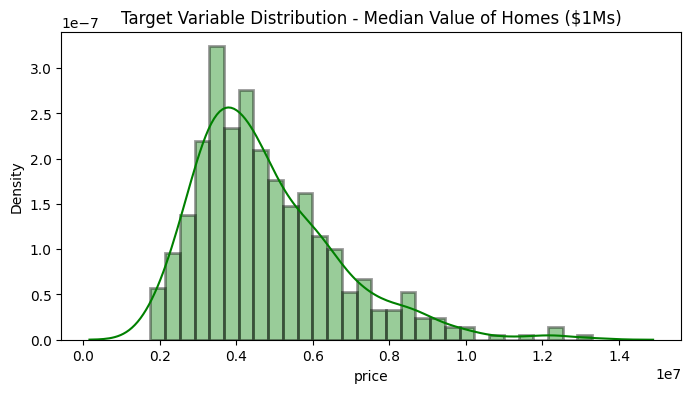

In [24]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

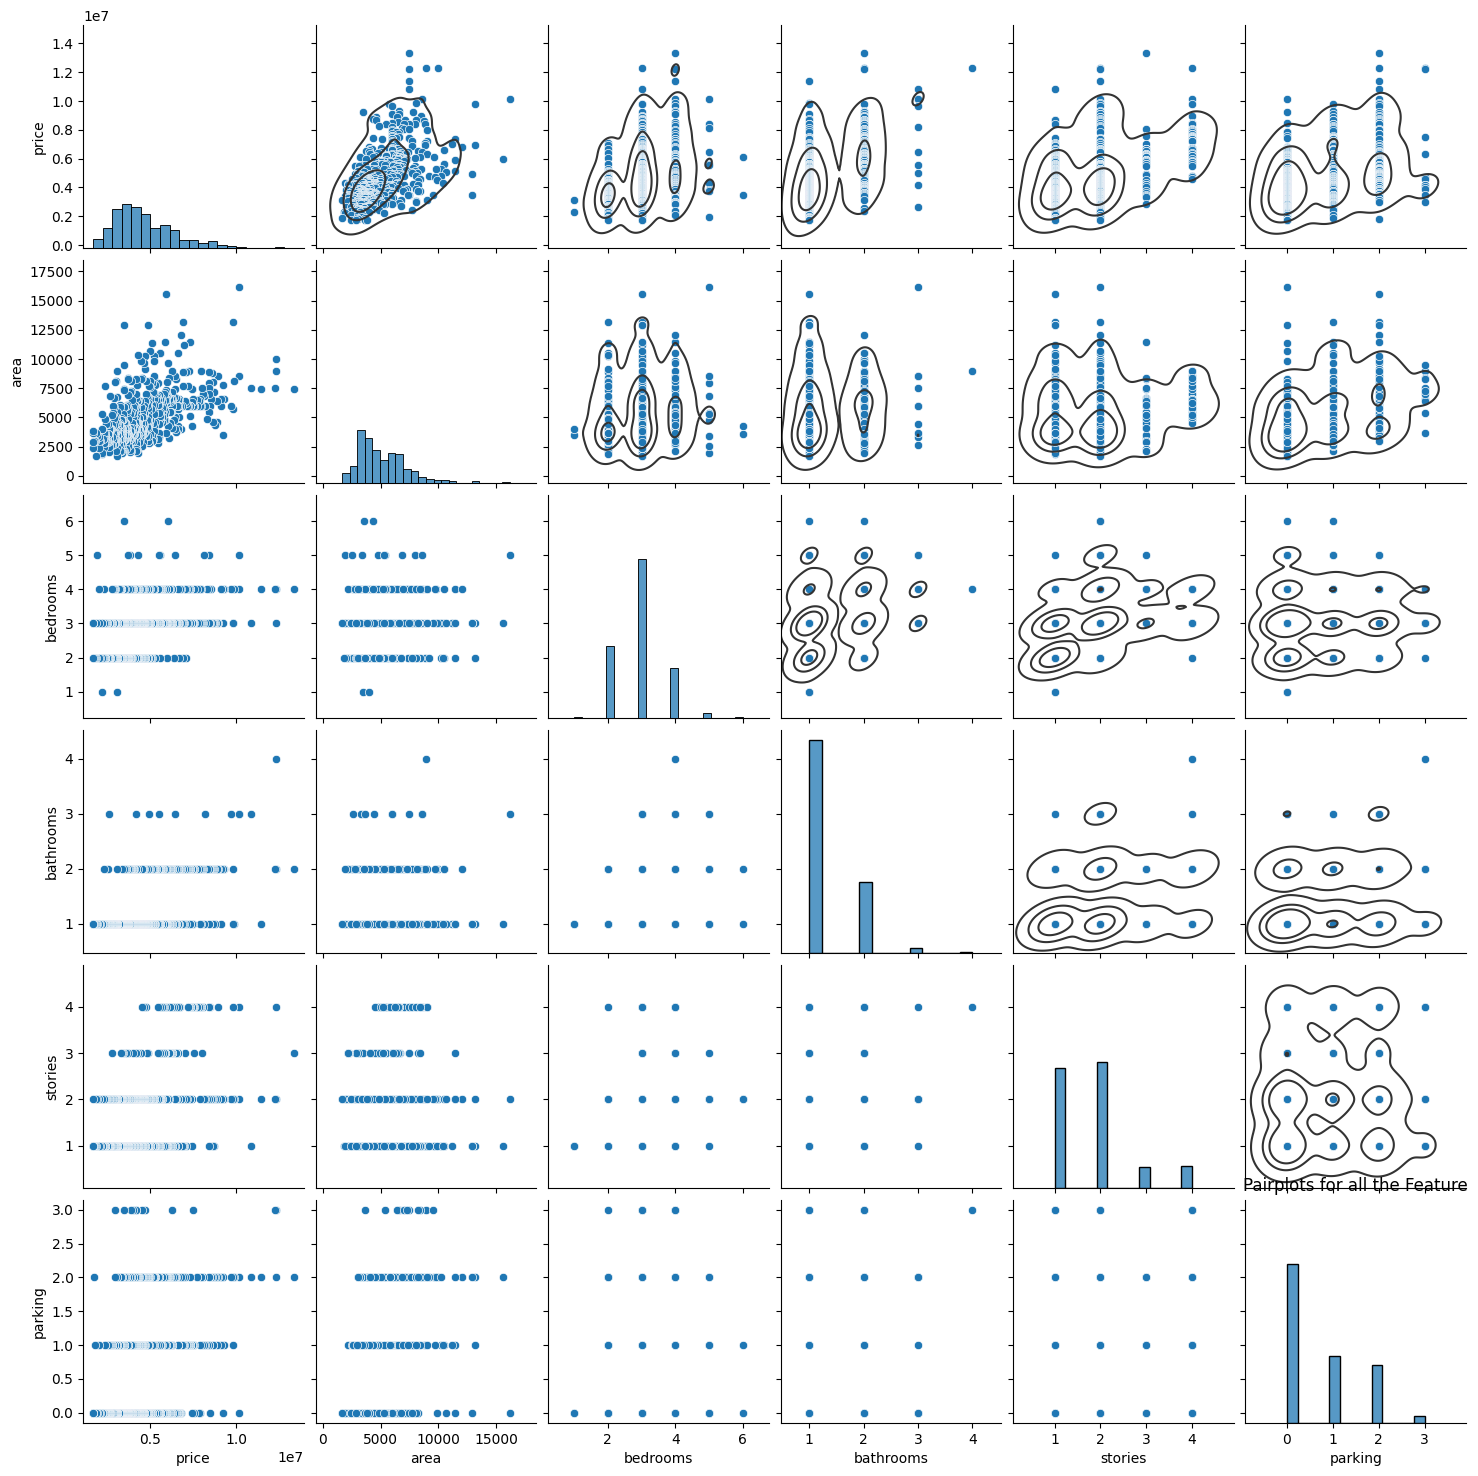

In [25]:
#Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

In [26]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [27]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                  Total Null Values  Percentage
price                             0         0.0
area                              0         0.0
bedrooms                          0         0.0
bathrooms                         0         0.0
stories                           0         0.0
mainroad                          0         0.0
guestroom                         0         0.0
basement                          0         0.0
hotwaterheating                   0         0.0
airconditioning                   0         0.0
parking                           0         0.0
prefarea                          0         0.0
furnishingstatus                  0         0.0


In [28]:
#Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape

One-Hot Encoding on features:
mainroad
guestroom
basement
hotwaterheating
airconditioning
prefarea

Dummy Encoding on features:
furnishingstatus
bathrooms
stories
parking
bedrooms


(545, 24)

In [29]:
df3

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
0,13300000,7420,True,False,False,False,True,True,False,False,...,True,False,False,True,False,False,False,True,False,False
1,12250000,8960,True,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,12250000,9960,True,False,True,False,False,True,True,False,...,False,False,False,True,False,False,True,False,False,False
3,12215000,7500,True,False,True,False,True,True,False,False,...,False,False,False,False,True,False,False,True,False,False
4,11410000,7420,True,True,True,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,True,False,True,False,False,False,False,True,...,False,False,False,True,False,True,False,False,False,False
541,1767150,2400,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
542,1750000,3620,True,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
543,1750000,2910,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [30]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
0,13300000,7420,True,False,False,False,True,True,False,False,...,True,False,False,True,False,False,False,True,False,False
1,12250000,8960,True,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,12250000,9960,True,False,True,False,False,True,True,False,...,False,False,False,True,False,False,True,False,False,False
3,12215000,7500,True,False,True,False,True,True,False,False,...,False,False,False,False,True,False,False,True,False,False
4,11410000,7420,True,True,True,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False



Inference:
Before removal of outliers, The dataset had 545 samples.
After removal of outliers, The dataset now has 533 samples.


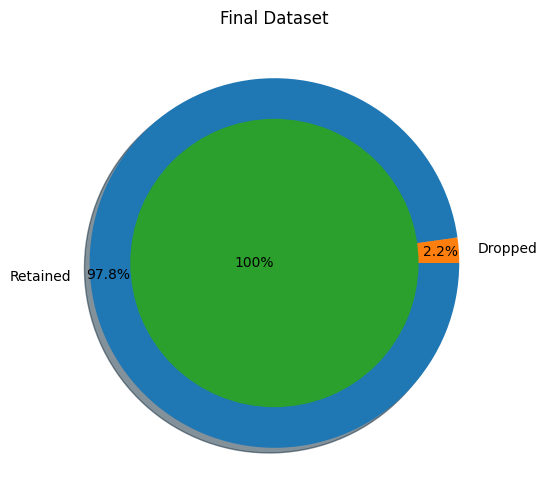


Inference: After the cleanup process, 12 samples were dropped, while retaining 2.2% of the data.


In [31]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

In [32]:
df

,price,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
0,13300000,7420,True,False,False,False,True,True,False,False,...,True,False,False,True,False,False,False,True,False,False
1,12250000,8960,True,False,False,False,True,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,12250000,9960,True,False,True,False,False,True,True,False,...,False,False,False,True,False,False,True,False,False,False
3,12215000,7500,True,False,True,False,True,True,False,False,...,False,False,False,False,True,False,False,True,False,False
4,11410000,7420,True,True,True,False,True,False,False,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,1820000,3000,True,False,True,False,False,False,False,True,...,False,False,False,True,False,True,False,False,False,False
529,1767150,2400,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
530,1750000,3620,True,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
531,1750000,2910,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [33]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))

df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (533, 23) (533,) 
Training set  --->  (426, 23) (426,) 
Testing set   --->  (107, 23)  (107,)


In [34]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,...,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02,4.260000e+02
mean,-6.463270e-17,9.799152e-17,-2.501911e-17,1.250956e-17,-3.544374e-17,1.355202e-17,-2.918896e-17,-1.876433e-17,-3.752867e-17,2.084926e-17,...,2.501911e-17,1.667941e-17,-1.459448e-17,-1.355202e-17,8.339703e-17,-8.756689e-17,2.501911e-17,1.667941e-17,8.339703e-17,-4.169852e-18
std,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,...,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00,1.001176e+00
min,-1.797874e+00,-2.335497e+00,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
25%,-7.487891e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,-1.078164e+00,-4.585055e-01,-1.469106e-01,-4.850713e-02
50%,-2.551019e-01,4.281744e-01,-4.659859e-01,-7.562775e-01,-2.038745e-01,-6.811149e-01,-5.393599e-01,-8.431153e-01,-6.996503e-01,-5.791573e-01,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,-5.972335e-01,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
75%,6.110159e-01,4.281744e-01,-4.659859e-01,1.322266e+00,-2.038745e-01,1.468181e+00,-5.393599e-01,1.186077e+00,1.429286e+00,1.150196e+00,...,-2.702737e-01,-2.752409e-01,-5.466082e-01,-4.919172e-01,-1.469106e-01,1.674387e+00,9.275031e-01,-4.585055e-01,-1.469106e-01,-4.850713e-02
max,2.992840e+00,4.281744e-01,2.145988e+00,1.322266e+00,4.904979e+00,1.468181e+00,1.854050e+00,1.186077e+00,1.429286e+00,1.726647e+00,...,3.699953e+00,3.633180e+00,1.829464e+00,2.032863e+00,6.806859e+00,1.674387e+00,9.275031e-01,2.180999e+00,6.806859e+00,2.061553e+01



                                          Standardardization on Testing set                                          


,area,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_semi_furnished,furnishingstatus_unfurnished,bathrooms_2,...,stories_3,stories_4,parking_1,parking_2,parking_3,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,1.070000e+02,107.000000
mean,0.025531,0.144059,0.022233,-0.154083,0.130350,0.001839,0.042216,0.029248,0.016627,-0.040418,...,0.063671,0.126559,0.008549,-0.019996,0.048055,-0.130171,0.121488,0.010192,-1.469106e-01,0.144615
std,1.021135,0.843283,1.023054,0.947331,1.269193,1.005431,1.031339,1.009305,1.010644,0.980290,...,1.107146,1.192583,1.010164,0.988902,1.153328,0.922384,0.987957,1.013435,1.952033e-16,1.997668
min,-1.635477,-2.335497,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
25%,-0.809959,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,-1.078164,-0.458505,-1.469106e-01,-0.048507
50%,-0.200970,0.428174,-0.465986,-0.756278,-0.203874,-0.681115,-0.539360,-0.843115,-0.699650,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
75%,0.762586,0.428174,-0.465986,1.322266,-0.203874,1.468181,-0.539360,1.186077,1.429286,-0.579157,...,-0.270274,-0.275241,-0.546608,-0.491917,-0.146911,-0.597234,0.927503,-0.458505,-1.469106e-01,-0.048507
max,2.867794,0.428174,2.145988,1.322266,4.904979,1.468181,1.854050,1.186077,1.429286,1.726647,...,3.699953,3.633180,1.829464,2.032863,6.806859,1.674387,0.927503,2.180999,-1.469106e-01,20.615528


                                       Correlation Matrix                                       


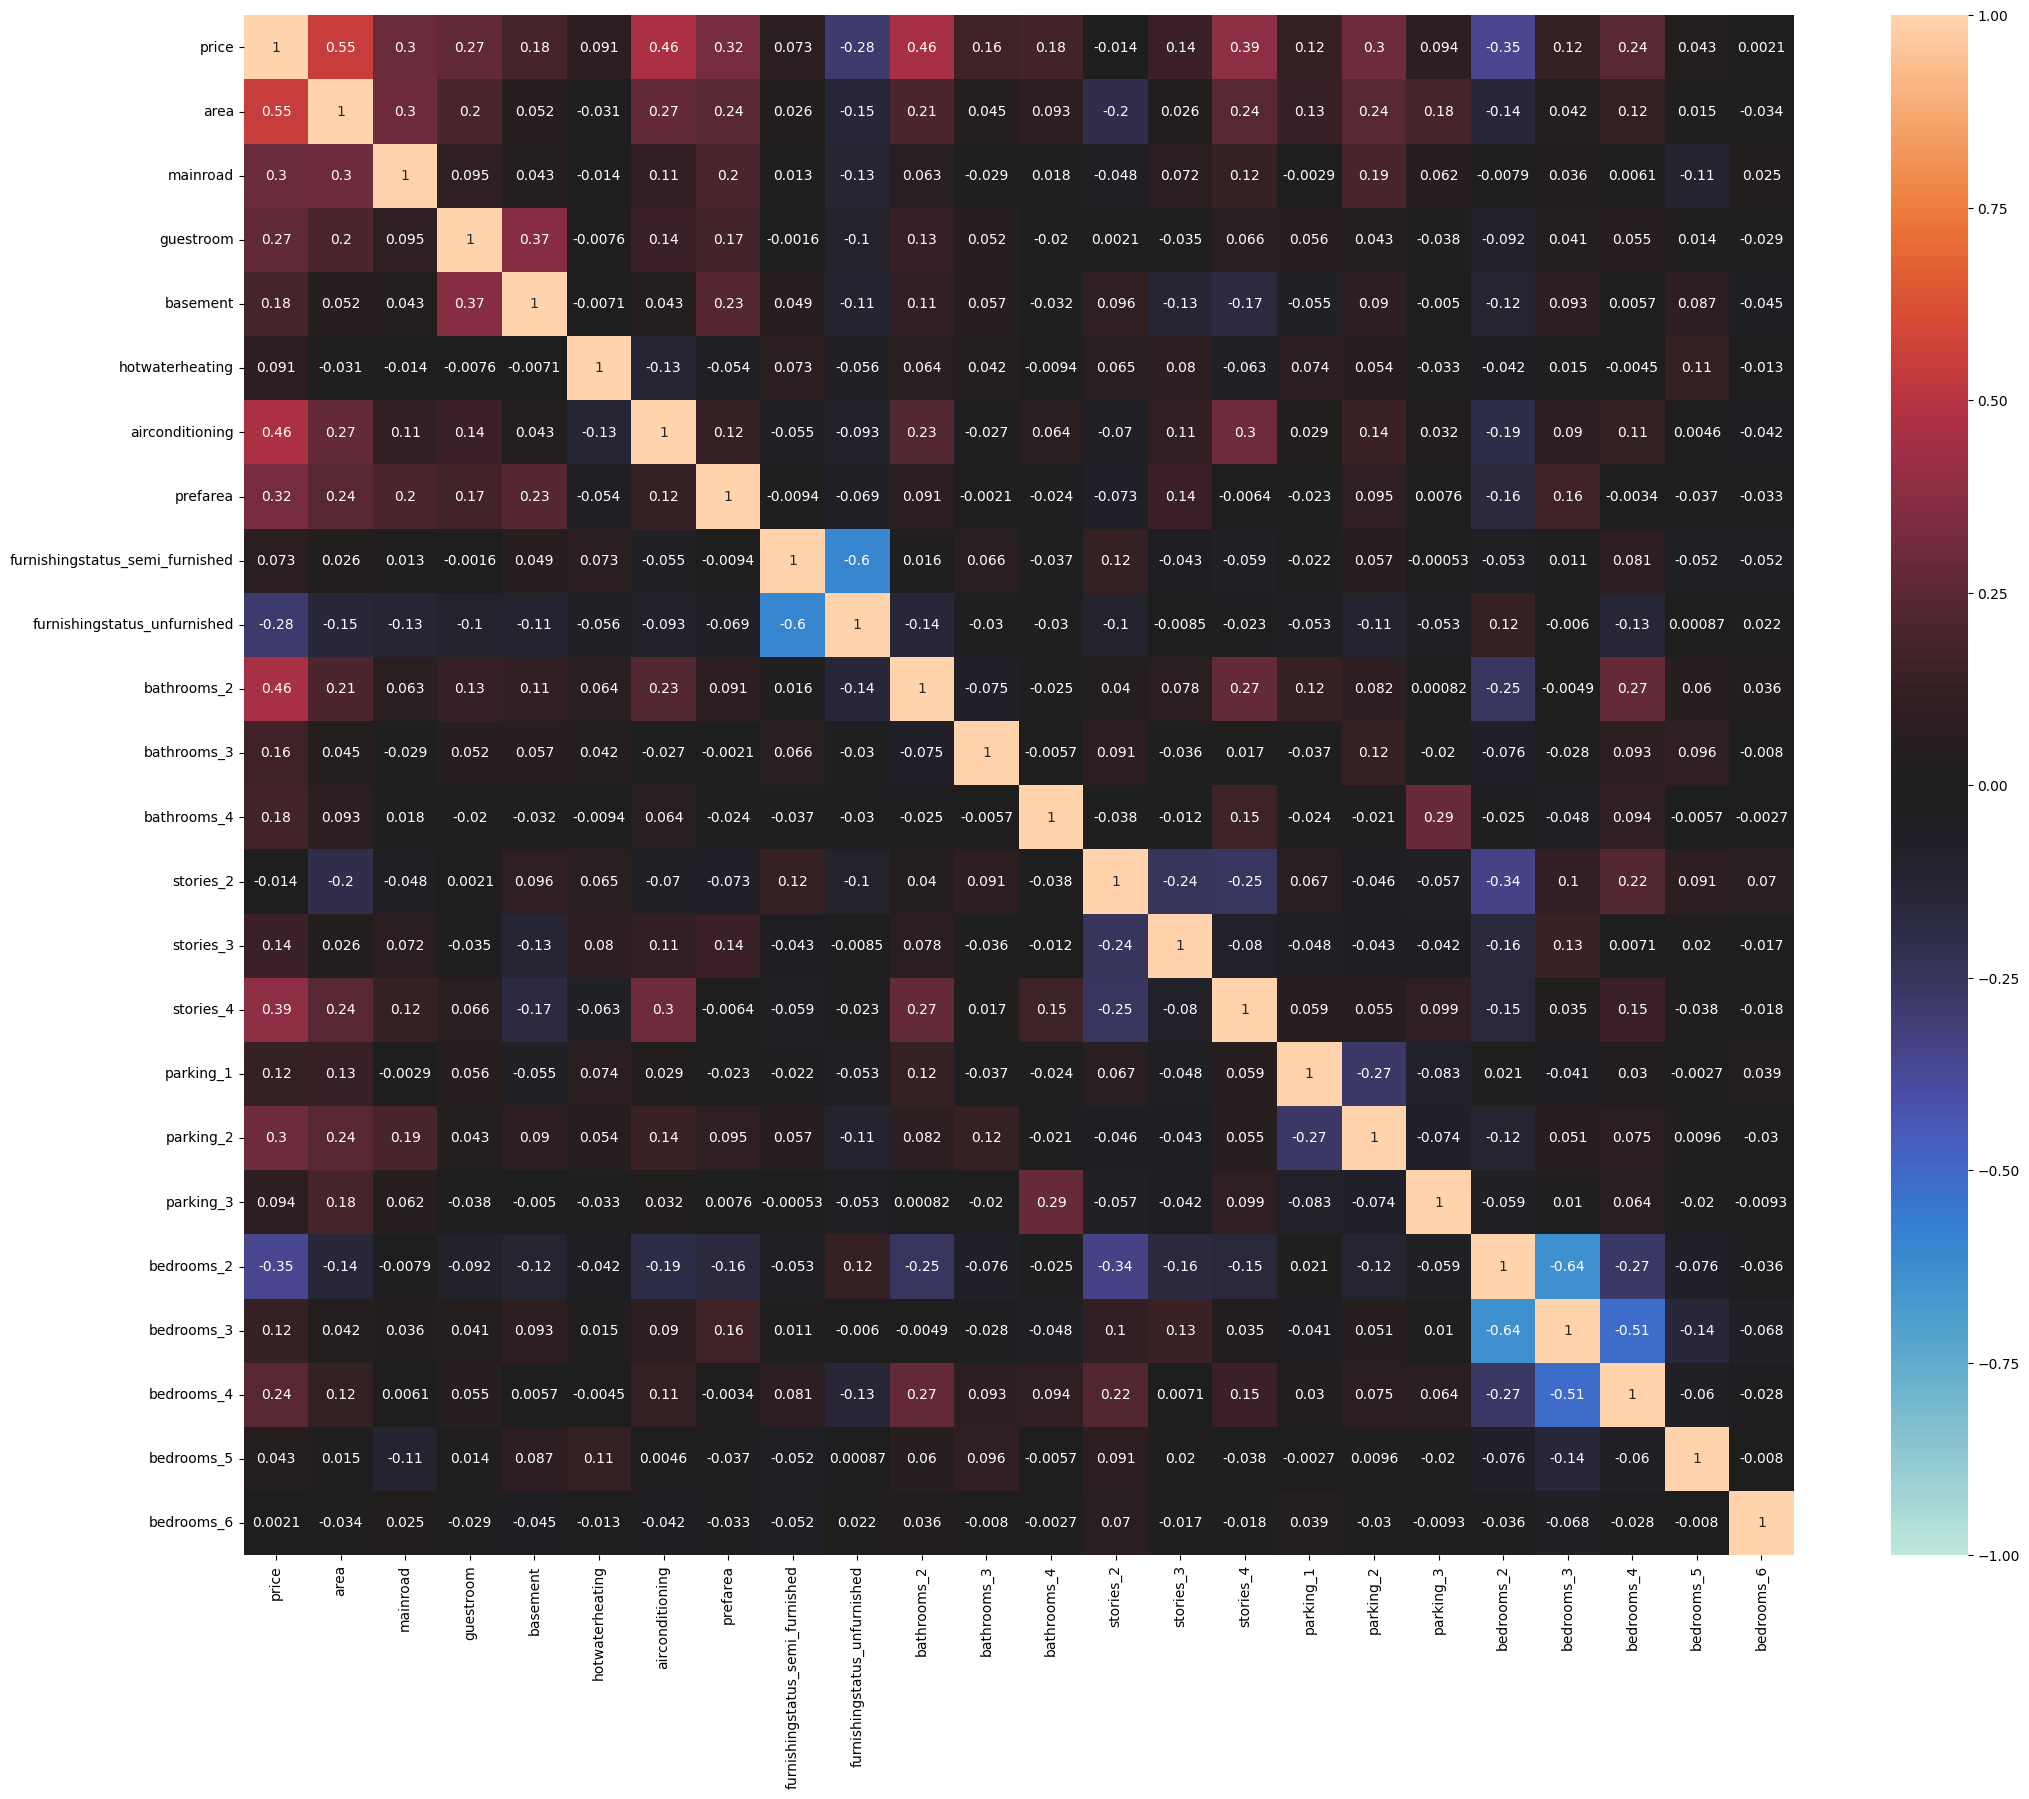

In [36]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [37]:
# Inference: There seems to be strong multi-correlation between the features. Let us try to fix these..

#-----------------------------------------------------------------------------
# Approach: We can fix these multicollinearity with two techniques:

# Manual Method - Variance Inflation Factor (VIF)
# Automatic Method - Recursive Feature Elimination (RFE)
# Feature Elmination using PCA Decomposition


#------------------------------------------------------------------------------
# prn : after try with those 3 step3
#  --> Inference:
# It can be seen that the performance of the modelsis quiet comparable unpon dropping features using VIF,
# RFE & PCA Techniques. Comparing the RMSE plots, the optimal values were found for dropping most features
#  using manual RFE Technique. But let us skip these for now, as the advanced ML Algorithms take care of multicollinearity.

In [38]:
# #Shortlisting the selected Features (with RFE)

lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-5)             # running RFE
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

#print(Train_X_std.loc[:,rfe.support_].columns)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

# Train_X_std = Train_X_std.loc[:,rfe.support_]
# Test_X_std = Test_X_std.loc[:,rfe.support_]

1052002.1523301557
1012519.989372006


In [39]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,1,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))

    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 435611.63113764  178535.44953021  119686.65946275  171210.9185958
  200580.08990409  363541.1687388   271064.49093887   15090.75518422
 -168847.55659801  372226.35414826  188596.74408113  280136.78367031
  134056.09983254  228899.77069     372492.97268413  166960.27915495
  278131.13351884  -57715.22044274  -33851.66099924  107659.40113262
  121541.66765655   39328.91553165   84618.74056581]
The Intercept of the Regresion Model was found to be  4716708.779342723


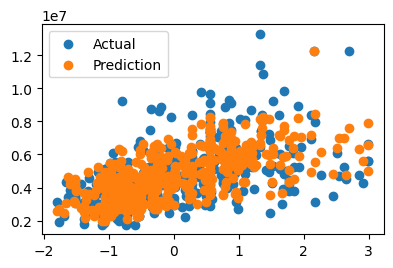



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.6789097089550895
Residual Sum of Squares (RSS) on Training set  ---> 466429810296572.75
Mean Squared Error (MSE) on Training set       ---> 1094905657973.1754
Root Mean Squared Error (RMSE) on Training set ---> 1046377.3974877207

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.686679497638552
Residual Sum of Squares (RSS) on Training set  ---> 116042808105904.83
Mean Squared Error (MSE) on Training set       ---> 1084512225288.8302
Root Mean Squared Error (RMSE) on Training set ---> 1041399.1671250896

--------------------Residual Plots--------------------


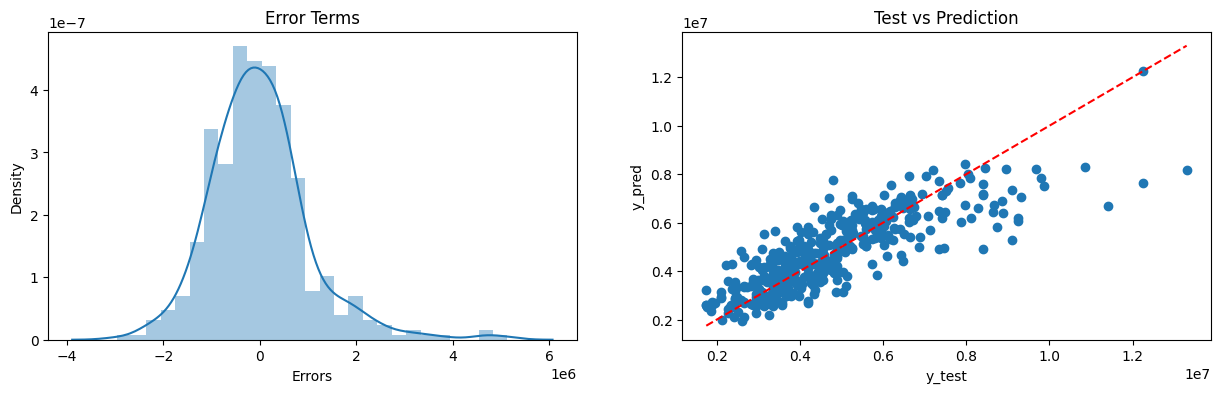

In [40]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

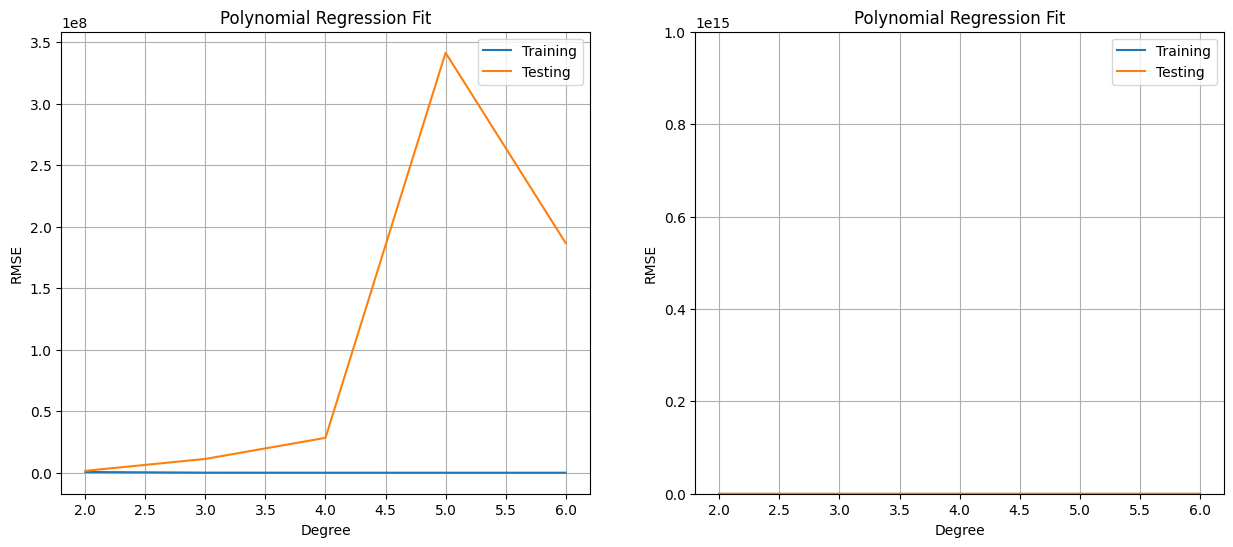

In [41]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=7

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)

    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))

    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,1e15])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 435611.63113764  178535.44953021  119686.65946275  171210.9185958
  200580.08990409  363541.1687388   271064.49093887   15090.75518422
 -168847.55659801  372226.35414826  188596.74408113  280136.78367031
  134056.09983254  228899.77069     372492.97268413  166960.27915495
  278131.13351884  -57715.22044274  -33851.66099924  107659.40113262
  121541.66765655   39328.91553165   84618.74056581]
The Intercept of the Regresion Model was found to be  4716708.779342723


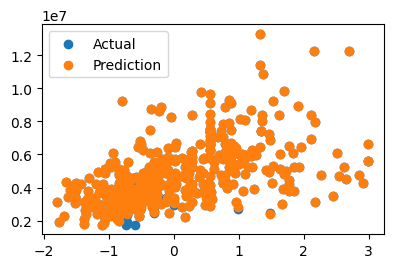



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9953436958127969
Residual Sum of Squares (RSS) on Training set  ---> 6763951260103.638
Mean Squared Error (MSE) on Training set       ---> 15877819859.398212
Root Mean Squared Error (RMSE) on Training set ---> 126007.22145733637

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -33666.43343473868
Residual Sum of Squares (RSS) on Training set  ---> 1.2469223967280409e+19
Mean Squared Error (MSE) on Training set       ---> 1.1653480343252718e+17
Root Mean Squared Error (RMSE) on Training set ---> 341371942.9486366

--------------------Residual Plots--------------------


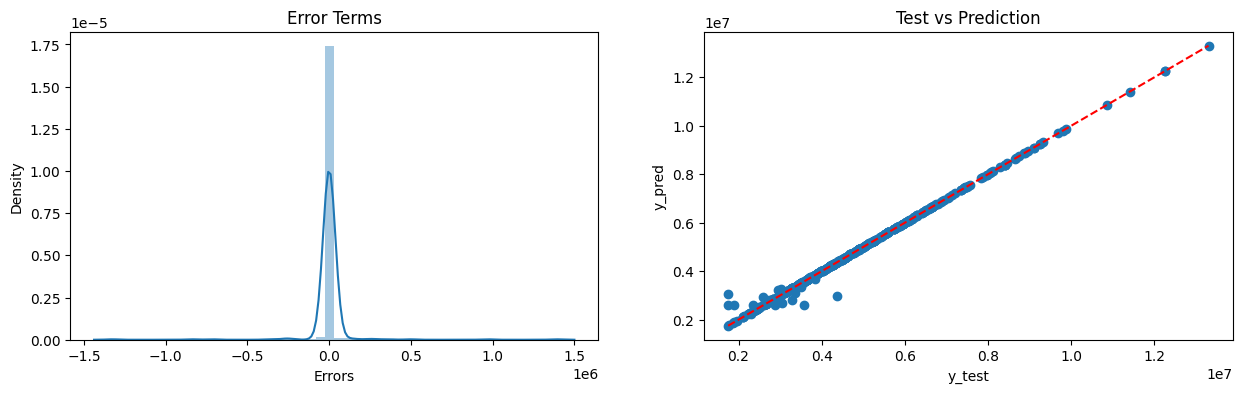

In [42]:
#Using the 5th Order Polynomial Regression model (degree=5)

poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)